## Calculate volume of difference maps in polygon regions


In [51]:
import json
from shapely.geometry import Polygon, Point
from descartes.patch import PolygonPatch
import shapely.vectorized
import numpy as np
import pandas as pd
import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
%matplotlib inline

#### Extract coordinates and maps from zipped file
This requires alot of memory

In [2]:
npzf = np.load("sandwich_maps.npz")
npzf.files
X=npzf['X']
Y=npzf['Y']
zmean=npzf['zmean']
zw = npzf['zw']

In [3]:
(num_maps,ysize,xsize)=np.shape(zw)
print(np.shape(npzf['zw']),num_maps,xsize,ysize)

(13, 6800, 8000) 13 8000 6800


#### Read a set of polygons that were saved in geojson format and build a shapely polygon

* Read the list of polygons (their names were not saved when exported from GlobalMapper)
* For each polygon, convert to a shapely Polygon

In [4]:
# array for masks
num_poly = 14
ma = np.empty((num_poly,ysize,xsize))
print(np.shape(ma))

(14, 6800, 8000)


In [ ]:
# here is how to get a single polygon
with open('Volume_polygons.geojson') as f:
    data = json.load(f)
    a=np.squeeze(data['features'][0]['geometry']['coordinates'])

    print(np.shape(a))

    # shapely.geometry.Polygon requires a sequence of coordinate tuples
    #(not an array)
    poly = Polygon(tuple(map(tuple,a)))
    # print(poly.wkt)
    print("area of polygon: ",poly.area)
    m = shapely.vectorized.contains(poly,X,Y)

Polygon
Area of polygon: A1 3851.4 m^2
Polygon
Area of polygon: A2 2628.6 m^2
Polygon
Area of polygon: B1 4112.7 m^2
Polygon
Area of polygon: B2 3026.3 m^2
Polygon
Area of polygon: C1 5095.6 m^2
Polygon
Area of polygon: C2 4037.0 m^2
Polygon
Area of polygon: D1 10104.0 m^2
Polygon
Area of polygon: D2 6086.1 m^2
Polygon
Area of polygon: E1 5773.3 m^2
Polygon
Area of polygon: E2 4431.7 m^2
Polygon
Area of polygon: G1 2228.2 m^2
Polygon
Area of polygon: G2 837.4 m^2
Polygon
Area of polygon: F1 11898.5 m^2
Polygon
Area of polygon: F2 4168.4 m^2


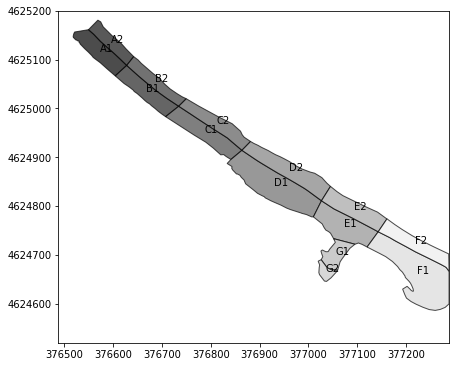

In [40]:
# plot all of the polygons
poly_names = ("A1","A2","B1","B2","C1","C2","D1","D2","E1","E2","G1","G2","F1","F2")
plt.figure(figsize=(7,7))
ax = plt.axes()
ax.set_aspect('equal')
# use bbox (bounding box) to set plot limits
plt.xlim(X[0][0],X[0][-1])
plt.ylim(Y[-1][0],Y[0][0])
with open('Volume_polygons.geojson') as f:
    data = json.load(f)
    i=0
    for feature in data['features']:
        print(feature['geometry']['type'])
        
        # convert to array
        a=np.squeeze( feature['geometry']['coordinates'] )
        #print(np.shape(a))
        
        # shapely.geometry.Polygon requires a sequence of coordinate tuples
        # (not an array)
        poly = Polygon(tuple(map(tuple,a)))
        xc=poly.centroid.x
        yc=poly.centroid.y
        print("Area of polygon: {} {:.1f} m^2".format(poly_names[i],poly.area))
        fc = np.array([1.,1.,1.])*i/14.
        patch = PolygonPatch(poly, facecolor=fc, edgecolor=[0,0,0], alpha=0.7, zorder=2)
        ax.add_patch(patch)
        plt.text(xc,yc,poly_names[i])
        i=i+1




In [43]:
# array for calulating areas
ones = np.ones((ysize,xsize))
# array for masks
num_poly = 14
ma = np.empty((num_poly,ysize,xsize))
print(np.shape(ma))
with open('Volume_polygons.geojson') as f:
    data = json.load(f)
    i=0
    for feature in data['features']:
        #print(feature['geometry']['type'])
        
        # convert to array
        a=np.squeeze( feature['geometry']['coordinates'] )
        print(np.shape(a))
        
        # shapely.geometry.Polygon requires a sequence of coordinate tuples
        #(not an array)
        poly = Polygon(tuple(map(tuple,a)))
        # print(poly.wkt)
        print("area of polygon: ",poly.area)
        ma[i,:,:] = shapely.vectorized.contains(poly,X,Y)
        area = np.sum(ma[i,:,:]*ones)*.1*.1
        print("{} Polygon area: {:.1f}; Mask area: {:.1f}".format(poly_names[i],poly.area,area))
        i = i+1


(14, 6800, 8000)
(29, 2)
area of polygon:  3851.411111796002
A1 Polygon area: 3851.4; Mask area: 3850.4
(18, 2)
area of polygon:  2628.5699590279273
A2 Polygon area: 2628.6; Mask area: 2627.9
(27, 2)
area of polygon:  4112.66189683504
B1 Polygon area: 4112.7; Mask area: 4111.5
(21, 2)
area of polygon:  3026.275690929956
B2 Polygon area: 3026.3; Mask area: 3025.5
(18, 2)
area of polygon:  5095.556622509981
C1 Polygon area: 5095.6; Mask area: 5094.3
(16, 2)
area of polygon:  4036.986501622286
C2 Polygon area: 4037.0; Mask area: 4035.8
(38, 2)
area of polygon:  10103.978989440355
D1 Polygon area: 10104.0; Mask area: 10101.1
(28, 3)
area of polygon:  6086.136576985397
D2 Polygon area: 6086.1; Mask area: 6084.5
(17, 2)
area of polygon:  5773.3487615553295
E1 Polygon area: 5773.3; Mask area: 5771.8
(16, 3)
area of polygon:  4431.689282105234
E2 Polygon area: 4431.7; Mask area: 4430.4
(20, 2)
area of polygon:  2228.2071176550103
G1 Polygon area: 2228.2; Mask area: 2227.7
(15, 2)
area of polyg

In [57]:
# make a dataframe to hold the results
df = pd.DataFrame(columns=poly_names)
df

,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,G1,G2,F1,F2


In [ ]:
# calculate total volume change
dz = zw[-1,:,:]-zw[0,:,:]
has_data = np.ones((ysize,xsize))
has_data[np.isnan(dz)]=0.
#plt.imshow(has_data)

In [49]:
for i in range(14):
    pdz = ma[i,:,:]*dz
    pdz[np.isnan(pdz)]=0.
    pa = np.sum(ma[i,:,:]*has_data)*.1*.1
    papct = 100.*pa/
    pv = np.sum(pdz)*.1*.1
    pdza = pv/pa
    print(i,pa,pv,pdza)
    
    

0 3850.39 -11286.0732117 -2.9311506657
1 2627.93 -2337.44614932 -0.889462865952
2 4111.46 -8213.54181286 -1.99771901292
3 3025.5 -1914.89305439 -0.632917882793
4 5094.34 -7642.71972402 -1.50023746433
5 4035.79 -1855.61801877 -0.459790528935
6 10101.07 2577.566737 0.25517759376
7 6084.45 202.787580594 0.0333288268609
8 5771.84 -1295.66944274 -0.224481178055
9 4430.36 -322.224286903 -0.0727309489304
10 2227.72 -255.667964178 -0.114766651185
11 837.13 1007.55690839 1.20358475791
12 11891.96 -2412.22998849 -0.202845450917
13 4167.3 -1101.8171769 -0.264395934274
